In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import glob
import datetime as dt

In [2]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 14,9

# Описание
Есть офиц. данные по ковиду по Италии https://github.com/pcm-dpc/COVID-19 c ежедневным обновлением. Воспользуюсь домашкой, чтобы ответить на некоторые вопросы, которые были в голове на эту тему :)

In [3]:
#Один файл соответствует одному дню
path = r'/Users/anastasia/Data_science/COVID/COVID-19/dati-andamento-nazionale'
all_files = glob.glob(path + "/*.csv")

In [4]:
# создаем ДФ для каждого файла и накапливаем в список, чтобы потом конкатенировать
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [5]:
# создаем общий ДФ, убирает повторки (какие дни повторяются из-за того, что добавляют какие-то заметки или обновляют последние данные)
dfr = pd.concat(li, axis=0, ignore_index=False).sort_values('data').drop_duplicates(subset='data', keep="last").reset_index(drop=True)

In [6]:
dfr.shape

(363, 24)

In [7]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   data                                    363 non-null    object 
 1   stato                                   363 non-null    object 
 2   ricoverati_con_sintomi                  363 non-null    int64  
 3   terapia_intensiva                       363 non-null    int64  
 4   totale_ospedalizzati                    363 non-null    int64  
 5   isolamento_domiciliare                  363 non-null    int64  
 6   totale_positivi                         363 non-null    int64  
 7   variazione_totale_positivi              363 non-null    int64  
 8   nuovi_positivi                          363 non-null    int64  
 9   dimessi_guariti                         363 non-null    int64  
 10  deceduti                                363 non-null    int64 

In [8]:
dfr.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Посмотрим абсолютное число новых заболевших с начала пандемии по дням.

In [21]:
check_1 = dfr[['data', 'nuovi_positivi']]
check_1.head(3)

,data,nuovi_positivi
0,2020-02-24T18:00:00,221
1,2020-02-25T18:00:00,93
2,2020-02-26T18:00:00,78


In [14]:
#танцы с бубном, чтобы дат на оси Х было не слишком много 
x = list(check_1['data'])
xdates = [dt.datetime.strptime(day,'%Y-%m-%dT%H:%M:%S') for day in x]

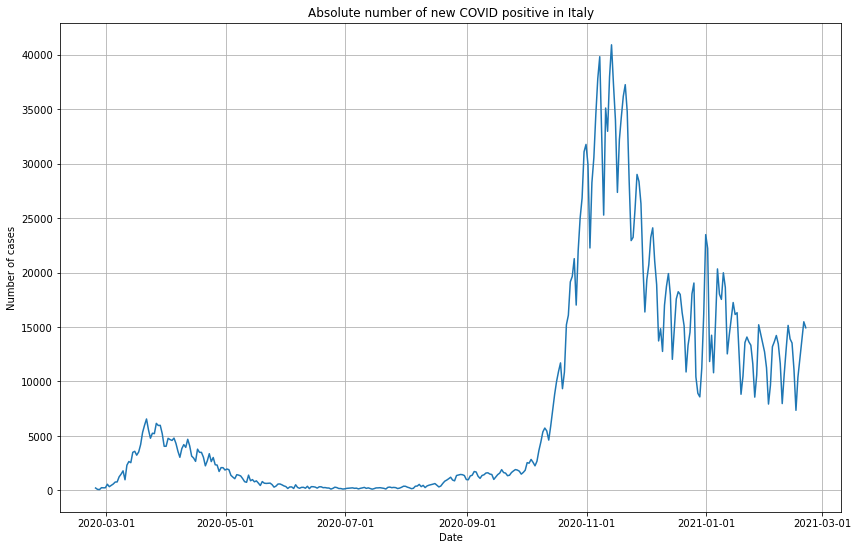

In [20]:
plt.plot(xdates, check_1['nuovi_positivi'])
plt.title('Absolute number of new COVID positive in Italy')
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# убрала, потому что с первой строкой слишком много дат, а последняя строка, которая разварачивает
# лейблы вертикально почему-то выводит пустой список перед графиком

#plt.gca().xaxis.set_major_locator(mdates.DayLocator((1,15))) 
#plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")

Выводы:
- мартовская волна 2020 года не была такой страшной, как ее малевали
- летние показатели не сильно отличаются от тех, при которых ввели первый локдаун, при том, что летом все было открыто
- Необходимо понять за счет чего такой пик в ноябре.


### Посмотрим на количество сделанных тестов

In [22]:
# колонна 'тесты' ('tamponi') имеет накопленные значения (каждное новое значение - сумма тестов сделанных за все время),
# поэтому здесь создам новую стобец 'tests_previous_day', чтобы использовать его для опредения разницы, а следовательно однодневных значений
prev_day = [0]
tamponi = list(dfr['tamponi'])
for i in tamponi:
    prev_day.append(i)
prev_day = prev_day[:-1]
print(prev_day[0:10])

[0, 4324, 8623, 9587, 12014, 15695, 18661, 21127, 23345, 25856]


In [23]:
dfr['tests_previous_day'] = prev_day
dfr[['tamponi','tests_previous_day']].head(4)

,tamponi,tests_previous_day
0,4324,0
1,8623,4324
2,9587,8623
3,12014,9587


In [24]:
# считаем саму разницу
dfr['diff_tamponi']  = dfr['tamponi'] - dfr['tests_previous_day']
dfr[['tamponi','tests_previous_day', 'diff_tamponi']].head(7)

,tamponi,tests_previous_day,diff_tamponi
0,4324,0,4324
1,8623,4324,4299
2,9587,8623,964
3,12014,9587,2427
4,15695,12014,3681
5,18661,15695,2966
6,21127,18661,2466


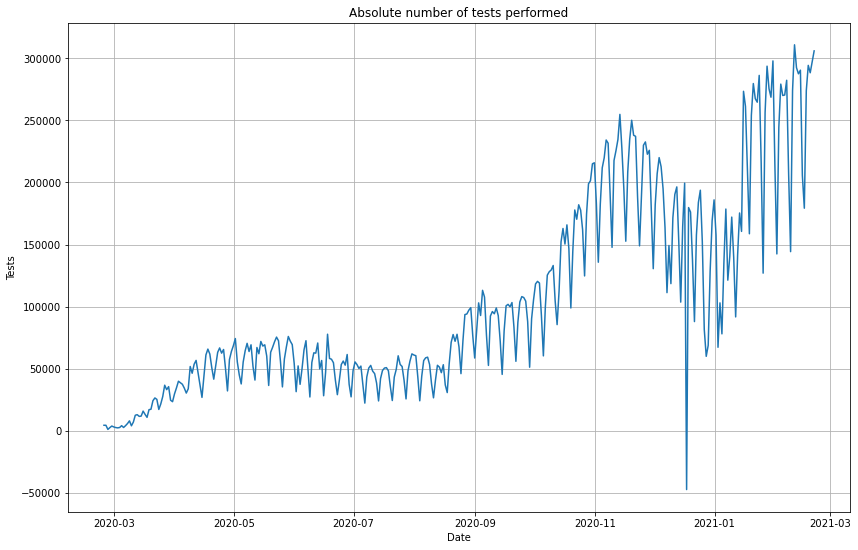

In [25]:
plt.plot(xdates, dfr['diff_tamponi'])
plt.title('Absolute number of tests performed')
plt.xlabel('Date')
plt.ylabel('Tests')
plt.grid()

Видно, что произошло многократное увеличение колчества делающихся ежедневно тестов. Это может объяснить и огромные цифры выявляемых ковид позитивных с осени 2021 года


Разберемся с отрицательным выпадом, которое явно является ошибочным

In [28]:
dfr[dfr['diff_tamponi'] == dfr['diff_tamponi'].min()][['tamponi', 'nuovi_positivi', 'diff_tamponi']]

,tamponi,nuovi_positivi,diff_tamponi
297,24635720,18236,-47510


In [31]:
# Посмотрим на значение вокруг проблемного места
dfr[['data','tamponi', 'tests_previous_day', 'diff_tamponi','nuovi_positivi']].iloc[294:301]

,data,tamponi,tests_previous_day,diff_tamponi,nuovi_positivi
294,2020-12-14T17:00:00,24319310,24215726,103584,12030
295,2020-12-15T17:00:00,24483741,24319310,164431,14844
296,2020-12-16T17:00:00,24683230,24483741,199489,17572
297,2020-12-17T17:00:00,24635720,24683230,-47510,18236
298,2020-12-18T17:00:00,24815520,24635720,179800,17992
299,2020-12-19T17:00:00,24991705,24815520,176185,16308
300,2020-12-20T17:00:00,25129125,24991705,137420,15104


Данные показывают, что 17 декабря количество тестов по сравнению с предыдущим днем уменишилось, чего быть не может.
Поэтому я приняла решение заменить разницу тестов за 17/12 на среднее число по близлежащим датам

In [32]:
print(dfr['diff_tamponi'].iloc[294:301:2].mean())
dfr['diff_tamponi'][297] = dfr['diff_tamponi'].iloc[294:301:2].mean()
print(dfr['diff_tamponi'][297])

155073.25
155073


/Users/anastasia/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


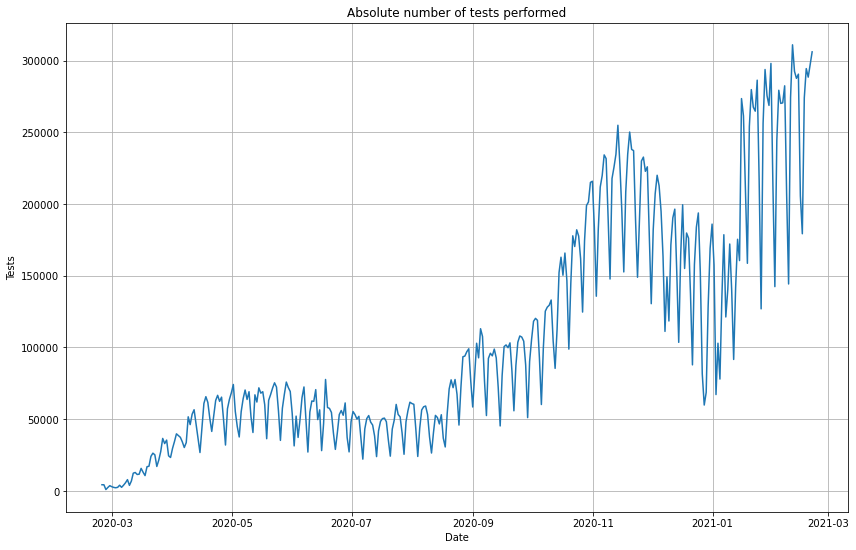

In [33]:
#пересчитаем график
plt.plot(xdates, dfr['diff_tamponi'])
plt.title('Absolute number of tests performed')
plt.xlabel('Date')
plt.ylabel('Tests')
plt.grid()

Зная, что количество тестов было увеличенно многократно, посмотрим на увеличение новых кейсов относительно числа сделанных тестов. Для этого добавим столбец 'относительное увеличение', котором будет лежать процент ковид-положительных от общего числа тестов

In [37]:
dfr ['relative_increase'] = dfr['nuovi_positivi'] / dfr['diff_tamponi'] * 100
check_2 = dfr[['data','relative_increase', 'nuovi_positivi', 'diff_tamponi']]
check_2.head(4)

,data,relative_increase,nuovi_positivi,diff_tamponi
0,2020-02-24T18:00:00,5.111008,221,4324
1,2020-02-25T18:00:00,2.163294,93,4299
2,2020-02-26T18:00:00,8.091286,78,964
3,2020-02-27T18:00:00,10.300783,250,2427


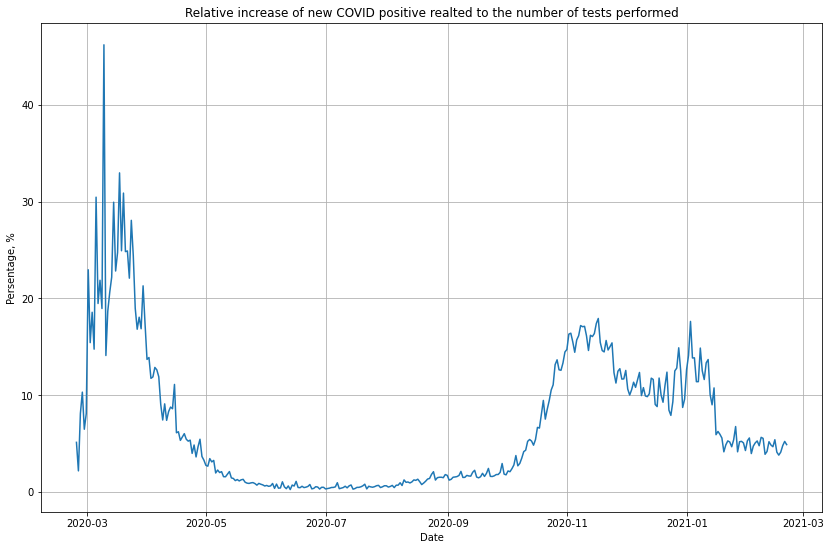

In [41]:
#построим график относительных значений
plt.plot(xdates, dfr['relative_increase'])
plt.title('Relative increase of new COVID positive realted to the number of tests performed')
plt.xlabel('Date')
plt.ylabel('Persentage, %')
plt.grid()

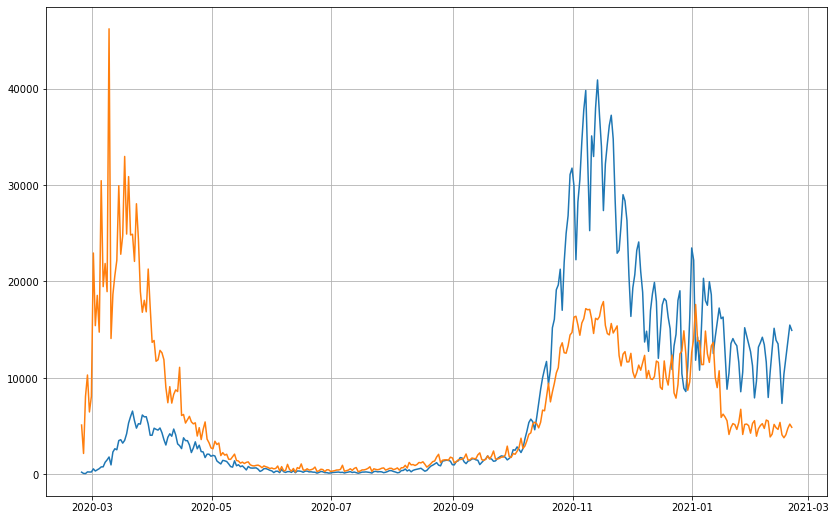

In [42]:
# Сравним графики, добавляя коэф
plt.plot(xdates, check_1['nuovi_positivi'])
plt.plot(xdates, dfr['relative_increase']* 1000) 
plt.grid()

### Выводы кэпа
- в начале пандемии при относительно маленьком количестве тестов выявлялось более 40% ковид положительных
- c мая по октябрь вирус был в отпуске, поскольку % выявленных случаев был одинаков по отношению к количеству тестов и всегда был очень мал
- с октября имеем повышение случаев, НО!
    - во-первых относительное повышение не такое драматичное, если сравнивать с абсолютными значениями
    - во-вторых уже сейчас относительные числа  на уровне конца апреля 2020, а значит может быть скоро снимут локдаун

## Самые пострадавшие регионы

In [43]:
# повторяем процедуру для получения инфы по регионам
path = r'/Users/anastasia/Data_science/COVID/COVID-19/dati-regioni'
all_files_re = glob.glob(path + "/*.csv")
li_re = []
for filename in all_files_re:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_re.append(df)

In [45]:
dfr_re = pd.concat(li_re, axis=0, ignore_index=False).sort_values('data').reset_index(drop=True)
dfr_re.tail(2)

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
15265,2021-02-20T17:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,249,36,285,6846,...,NaN,2.0,NaN,NaN,41482.0,9795.0,475986.0,190172.0,ITH,ITH1
15266,2021-02-20T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,567,75,642,11841,...,Dal totale dei casi positivi è stato sottratto...,5.0,NaN,NaN,50590.0,0.0,704882.0,193846.0,ITF,ITF1


In [46]:
dfr_re.shape

(15267, 30)

In [47]:
dfr_re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15267 entries, 0 to 15266
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   data                                    15267 non-null  object 
 1   stato                                   15267 non-null  object 
 2   codice_regione                          15267 non-null  int64  
 3   denominazione_regione                   15267 non-null  object 
 4   lat                                     15267 non-null  float64
 5   long                                    15267 non-null  float64
 6   ricoverati_con_sintomi                  15267 non-null  int64  
 7   terapia_intensiva                       15267 non-null  int64  
 8   totale_ospedalizzati                    15267 non-null  int64  
 9   isolamento_domiciliare                  15267 non-null  int64  
 10  totale_positivi                         15267 non-null  in

In [51]:
# количество представленных регионов
len(dfr_re.drop_duplicates(subset='denominazione_regione', keep="last"))

21

In [54]:
# создадим ДФ с последними данными о количестве умерших и вылечившихся
check_3 = dfr_re[dfr_re['data']=='2021-02-20T17:00:00'][['denominazione_regione', 'deceduti', 'dimessi_guariti']].drop_duplicates(subset='denominazione_regione', keep="last")

In [56]:
# отсортируем по количеству умерших
check_3 = check_3.sort_values('deceduti', ascending = False)

In [57]:
# для понимания добавим столбец с количеством населения (на конец 2019 года)
population_by_regione = [10027602, 4464119, 4879133, 4311217, 5755700, 3692555, 5712143, 4875290, 3953305, 1524826, 1206216, 1512672, 1293941, 1078069, 1611621, 532644, 870165,1894110, 125034, 553254, 300516]
check_3['population'] = population_by_regione

In [58]:
# и добавим процент умерших от общего числа людей 
check_3['rel'] = check_3['deceduti'] / check_3['population'] * 100
check_3.set_index('denominazione_regione', inplace=True)
check_3.head(3)

,denominazione_regione,deceduti,dimessi_guariti,population,rel
15253,Lombardia,28008,495393,10027602,0.279309
15249,Emilia-Romagna,10304,198733,4464119,0.230818
15255,Veneto,9701,294301,4879133,0.198826
15258,Piemonte,9257,216282,4311217,0.214719
15251,Lazio,5704,183616,5755700,0.099102


<AxesSubplot:title={'center':'Mortality by region'}, xlabel='denominazione_regione', ylabel='rel'>

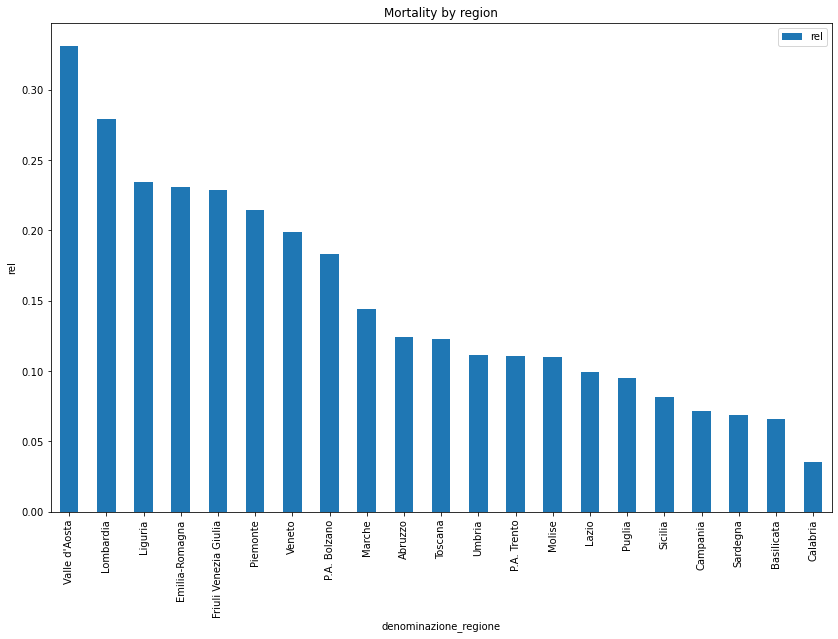

In [81]:
check_3.drop('population', axis = 1).drop('dimessi_guariti', axis = 1).drop('deceduti', axis = 1).sort_values('rel', ascending = False).plot(kind='bar',
             title='Mortality by region',
             xlabel='denominazione_regione',
             ylabel='rel')

Валле Д'Аоста, Ломбардия и Лигурия - самые пострадавшие регионы

### Посмотрим долю смертей на долю излечившихся

<AxesSubplot:title={'center':'Proportion of recovers and deaths'}, ylabel='None'>

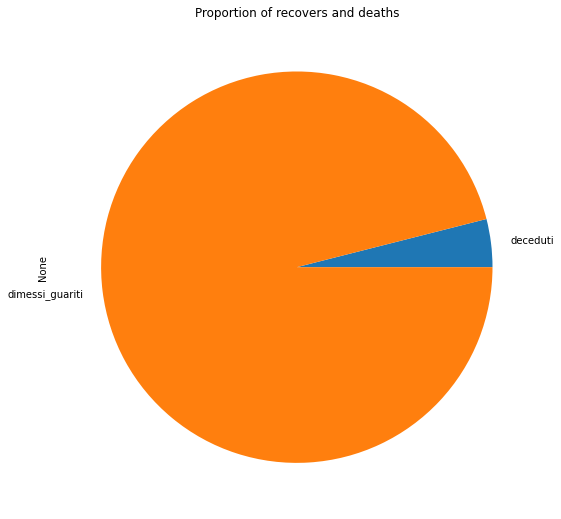

In [88]:
check_3[['deceduti', 'dimessi_guariti']].sum().plot(kind='pie', title='Proportion of recovers and deaths')

 Добавим данные по плотности населения (человек на 1 км^2) в регионах и посмотрем коррелирует она ли смертностью (будет использовать относительную смертность)

In [91]:
density = [420, 199,266, 170,334,161, 418, 189,202,282,152,160,119, 79,67,71.9, 103,124,38,55,67]

In [92]:
check_3['density'] = density

In [93]:
check_3.head(3)

,deceduti,dimessi_guariti,population,rel,density
denominazione_regione,,,,,
Lombardia,28008,495393,10027602,0.279309,420.0
Emilia-Romagna,10304,198733,4464119,0.230818,199.0
Veneto,9701,294301,4879133,0.198826,266.0


<AxesSubplot:title={'center':'Correlation between density and deaths'}, xlabel='rel', ylabel='density'>

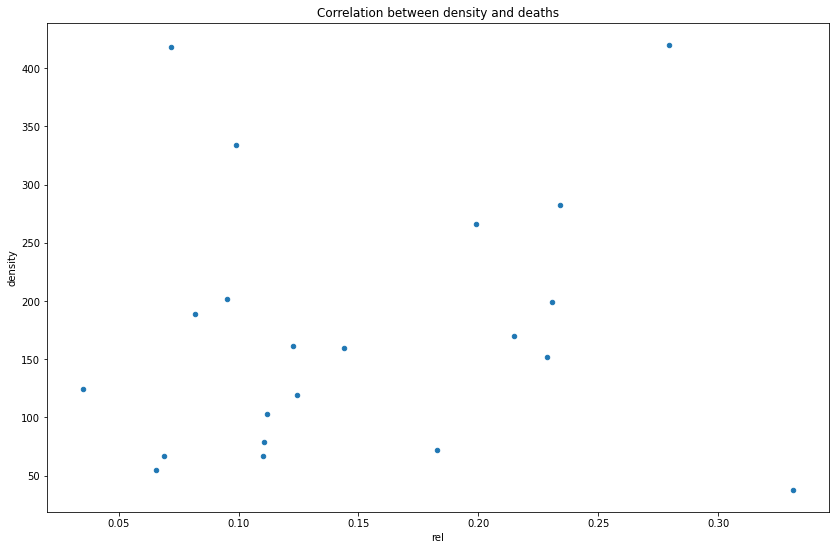

In [95]:
check_3.plot(kind='scatter', 
        x='rel', 
        y='density', 
        title='Correlation between density and deaths')

In [99]:
check_3['density'].corr(check_3['rel'])

0.13789753532282473

Не похоже, чтобы была какая-то зависимость между количеством смертей на человека в регионах с его плотностью